In [1]:
from PIL import Image
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as img

from skimage import io
from skimage import color
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/CMPE 255 - Team 2 (Spring 21)/GroupProject/train.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/CMPE 255 - Team 2 (Spring 21)/GroupProject/test.csv')
print("Training Data:",train_df.shape)
print("Test Data    :",test_df.shape)
train_df.head()

Training Data: (6800, 2)
Test Data    : (200, 2)


,ID,RESULT
0,Tuberculosis-1017,1
1,Normal-2255,0
2,Tuberculosis-3366,1
3,Normal-246,0
4,Normal-1252,0


In [4]:
num_images         = 6800
im_size            = 224
path_to_img_folder = '/content/drive/MyDrive/CMPE 255 - Team 2 (Spring 21)/GroupProject/Images'

N = train_df.shape[0]
x_train = np.empty((num_images, im_size, im_size), dtype=np.float32)

for i, image_id in enumerate(train_df['ID']):
    img = color.rgb2gray(io.imread(f'{path_to_img_folder}/{image_id}.png'))
    x_train[i, :, :] = resize(img, (im_size, im_size))

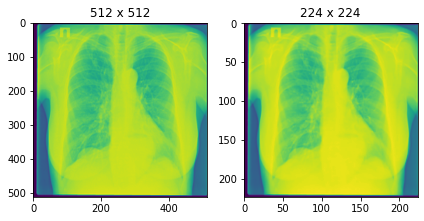

In [5]:
id = train_df['ID'][0]
fig, (ax1, ax2) = plt.subplots(1, 2)
    
ax1.imshow(io.imread(f'{path_to_img_folder}/{id}.png'))
ax1.set_title("512 x 512")
ax2.imshow(x_train[0,:,:])
ax2.set_title("224 x 224")
fig.tight_layout()

In [6]:
y_train = pd.get_dummies(train_df['RESULT']).values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=0)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(5440, 224, 224)
(1360, 224, 224)
(5440, 2)
(1360, 2)


In [8]:
rgb_train = np.repeat(X_train[..., np.newaxis], 3, -1)

In [9]:
rgb_val = np.repeat(X_test[..., np.newaxis], 3, -1)

In [10]:
BATCH_SIZE = 64

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [11]:
data_generator = create_datagen().flow(rgb_train,y_train, batch_size=BATCH_SIZE, seed=0)

In [14]:
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization

dnn121 = tf.keras.applications.DenseNet121(
    include_top=False,
    input_tensor=None,
    input_shape=(224,224,3),
    weights = 'imagenet'
)

dnn121.trainable= False

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = Dense(2, activation='softmax')

model = Sequential([
    dnn121,
    global_avg_layer,
    
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    predictions
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [16]:
history = model.fit(
    data_generator,
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(rgb_val, y_test)
)

Epoch 1/15
85/85 [==============================] - 79s 927ms/step - loss: 0.4782 - accuracy: 0.8467 - val_loss: 0.8930 - val_accuracy: 0.6669
Epoch 2/15
85/85 [==============================] - 73s 861ms/step - loss: 0.2925 - accuracy: 0.8851 - val_loss: 0.3279 - val_accuracy: 0.8662
Epoch 3/15
85/85 [==============================] - 73s 859ms/step - loss: 0.2304 - accuracy: 0.9101 - val_loss: 0.2904 - val_accuracy: 0.8853
Epoch 4/15
85/85 [==============================] - 73s 859ms/step - loss: 0.2242 - accuracy: 0.9086 - val_loss: 0.1475 - val_accuracy: 0.9404
Epoch 5/15
85/85 [==============================] - 73s 860ms/step - loss: 0.1883 - accuracy: 0.9233 - val_loss: 0.1609 - val_accuracy: 0.9404
Epoch 6/15
85/85 [==============================] - 73s 862ms/step - loss: 0.1788 - accuracy: 0.9235 - val_loss: 0.1639 - val_accuracy: 0.9441
Epoch 7/15
85/85 [==============================] - 74s 865ms/step - loss: 0.1716 - accuracy: 0.9300 - val_loss: 0.1359 - val_accuracy: 0.9463

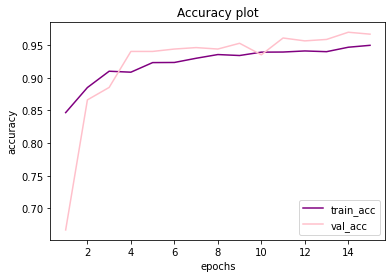

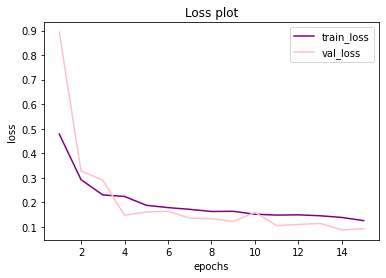

In [17]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [27]:
model.save('/content/drive/MyDrive/denseNet121.h5')

In [24]:
results = model.evaluate(rgb_val, y_test)

43/43 [==============================] - 9s 204ms/step - loss: 0.0928 - accuracy: 0.9669
